In [ ]:
! pip install transformers plotly datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.6 MB/s eta 0:00:00


In [1]:
! rm -rf space-model
! rm -rf nano-BERT
! git clone https://github.com/StepanTita/space-model.git
! git clone https://github.com/StepanTita/nano-BERT.git

Cloning into 'space-model'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 50 (delta 17), reused 39 (delta 10), pack-reused 0
Unpacking objects: 100% (50/50), 27.83 MiB | 4.31 MiB/s, done.
Cloning into 'nano-BERT'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 56 (delta 25), reused 30 (delta 8), pack-reused 0
Unpacking objects: 100% (56/56), 39.04 MiB | 4.40 MiB/s, done.


In [1]:
import sys

sys.path.append('space-model')

In [2]:
import math
import json
from collections import Counter
import random
import os

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

from datasets import load_dataset, Dataset

from space_model.model import *
from space_model.loss import *

/home/stepan/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
SEED = 42

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=SEED)

In [5]:
def on_gpu(f):
    def wrapper(*args):
        if torch.cuda.is_available():
            return f(*args)
        else:
            print('cuda unavailable')
    return wrapper

In [6]:
if torch.cuda.is_available():
    ! pip install pynvml
    from pynvml import *
    from numba import cuda

@on_gpu
def print_gpu_utilization(dev_id):
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(dev_id)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    except Exception as e:
        print(e)

@on_gpu
def free_gpu_cache(dev_id=0):
    print("Initial GPU Usage")
    print_gpu_utilization(dev_id)

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization(dev_id)

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [10]:
device_id = 1

In [11]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [12]:
torch.cuda.set_device(device)

In [158]:
MODEL_NAME = 'distilbert-base-cased'
MODELS_PATH = 'models'
DATASET_NAME = 'imdb'

NUM_EPOCHS = 15
BATCH_SIZE = 256
MAX_SEQ_LEN = 256
LEARNING_RATE = 2e-4
MAX_GRAD_NORM = 1000

In [14]:
dataset = load_dataset(DATASET_NAME)
dataset

Found cached dataset imdb (/home/stepan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [15]:
test_split, val_split = train_test_split(dataset['test'], test_size=0.2, random_state=SEED)

In [16]:
dataset['val'] = Dataset.from_dict(val_split)
dataset['test'] = Dataset.from_dict(test_split)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

In [17]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [18]:
tokenized_dataset = dataset.map(lambda x: tokenizer(x['text'], truncation=True, padding=True, max_length=MAX_SEQ_LEN, return_tensors='pt'), batched=True)
tokenized_dataset.set_format('torch', device=device)
tokenized_dataset

Loading cached processed dataset at /home/stepan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-ecfacd62b1f6155f.arrow


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Loading cached processed dataset at /home/stepan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-7ee3dfd079463cf3.arrow


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 20000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
})

In [159]:
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
base_model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [160]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [161]:
for p in base_model.distilbert.parameters():
    p.requires_grad = False
# for p in base_model.pre_classifier.parameters():
#     p.requires_grad = True

In [162]:
count_parameters(base_model)

592130

In [163]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

def train(f):
    def wrapper(model, *args, **kwargs):
        model.train()
        return f(model, *args, **kwargs)
    return wrapper

In [164]:
@train
def train_epoch(model, train_dataloader, optimizer):
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for step, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        targets = batch['label'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets) # (B, Seq_Len, 2)

        loss, logits = outputs.loss, outputs.logits

        probs = F.softmax(logits, dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in targets.cpu()]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss, train_preds, train_labels

@eval
def eval_epoch(model, val_dataloader):
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():

        for step, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['label'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)

            loss, logits = outputs.loss, outputs.logits

            probs = F.softmax(logits, dim=-1).cpu()
            pred = torch.argmax(probs, dim=-1) # (B)
            val_preds += pred.detach().tolist()
            val_labels += [l.item() for l in targets.cpu()]

            val_loss += loss.item()
    return val_loss, val_preds, val_labels

In [165]:
def training(model, train_data, val_data, config):
    model = model.to(device)

    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['epochs'])

    print(f'Train steps: {num_train_steps}')

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=2 * config['batch_size'])

    history = {
        'train_losses': [],
        'val_losses': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
    }

    for epoch_num in range(config['epochs']):
        print(f'Epoch: {epoch_num + 1}')

        # train stage
        train_loss, train_preds, train_labels = train_epoch(model, train_dataloader, optimizer)

        # eval stage
        val_loss, val_preds, val_labels = eval_epoch(model, val_dataloader)

        # metrics
        train_acc = accuracy_score(train_labels, train_preds)
        val_acc = accuracy_score(val_labels, val_preds)
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        train_precision = precision_score(train_labels, train_preds)
        val_precision = precision_score(val_labels, val_preds)
        train_recall = recall_score(train_labels, train_preds)
        val_recall = recall_score(val_labels, val_preds)

        history['train_losses'].append(train_loss / len(train_dataloader))
        history['val_losses'].append(val_loss / len(val_dataloader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)

        print()
        print(f'Train loss: {train_loss / len(train_dataloader)} | Val loss: {val_loss / len(val_dataloader)}')
        print(f'Train acc: {train_acc} | Val acc: {val_acc}')
        print(f'Train f1: {train_f1} | Val f1: {val_f1}')
        print(f'Train precision: {train_precision} | Val precision: {val_precision}')
        print(f'Train recall: {train_recall} | Val recall: {val_recall}')

    free_gpu_cache(device_id)
    return history

In [166]:
ids = tokenized_dataset['test'][0]['input_ids'].unsqueeze(0)
mask = tokenized_dataset['test'][0]['attention_mask'].unsqueeze(0)
targets = tokenized_dataset['test'][0]['label'].unsqueeze(0)

ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)

out = base_model(ids, mask, labels=targets)
out.loss

tensor(0.8696, device='cuda:1', grad_fn=<NllLossBackward0>)

In [167]:
config = {
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'gradient_accumulation_steps': 1,
    'fp16': False,
    'lr': LEARNING_RATE,
    'max_grad_norm': MAX_GRAD_NORM,
    'weight_decay': 0.01,
}

In [ ]:
history = training(base_model, tokenized_dataset['train'], tokenized_dataset['val'], config)

Train steps: 1464
Epoch: 1


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.6319324301213635 | Val loss: 0.5648875534534454
Train acc: 0.68172 | Val acc: 0.767
Train f1: 0.6814766578497068 | Val f1: 0.7664929253770318
Train precision: 0.6923532898636633 | Val precision: 0.7892199824715163
Train recall: 0.65408 | Val recall: 0.7247484909456741
Epoch: 2


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.5305160232344452 | Val loss: 0.5162103176116943
Train acc: 0.76332 | Val acc: 0.7542
Train f1: 0.7632819399021742 | Val f1: 0.7484336051601366
Train precision: 0.7701715505212181 | Val precision: 0.6919315403422983
Train recall: 0.75064 | Val recall: 0.9110663983903421
Epoch: 3


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.4889248360176476 | Val loss: 0.4686776876449585
Train acc: 0.7812 | Val acc: 0.7976
Train f1: 0.7811663521383048 | Val f1: 0.7975625571705742
Train precision: 0.7883511074651354 | Val precision: 0.7851335656213705
Train recall: 0.7688 | Val recall: 0.8160965794768612
Epoch: 4


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.47023867557243426 | Val loss: 0.45539568066596986
Train acc: 0.78912 | Val acc: 0.8012
Train f1: 0.7890858744319458 | Val f1: 0.8009304120011485
Train precision: 0.7966672139221803 | Val precision: 0.7762134123749537
Train recall: 0.7764 | Val recall: 0.8430583501006036
Epoch: 5


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.45748937129974365 | Val loss: 0.5099132269620895
Train acc: 0.79504 | Val acc: 0.7348
Train f1: 0.7949979617900398 | Val f1: 0.7232841950616873
Train precision: 0.8037390874649976 | Val precision: 0.6639321074964639
Train recall: 0.78072 | Val recall: 0.9444668008048289
Epoch: 6


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.4549690810393314 | Val loss: 0.44303703904151914
Train acc: 0.79292 | Val acc: 0.8054
Train f1: 0.7928938347041314 | Val f1: 0.8042634675686291
Train precision: 0.7996562730174319 | Val precision: 0.8542642924086223
Train recall: 0.78168 | Val recall: 0.7336016096579477
Epoch: 7


 48%|████▊     | 47/98 [00:28<00:31,  1.63it/s]

In [169]:
def plot_results(history, do_val=True):
    fig, ax = plt.subplots(figsize=(8, 8))

    x = list(range(0, len(history['train_losses'])))

    # loss

    ax.plot(x, history['train_losses'], label='train_loss')

    if do_val:
        ax.plot(x, history['val_losses'], label='val_loss')

    plt.title('Train / Validation Loss')
    plt.legend(loc='upper right')

    # accuracy

    if 'train_acc' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_acc'], label='train_acc')

        if do_val:
            ax.plot(x, history['val_acc'], label='val_acc')

    plt.title('Train / Validation Accuracy')
    plt.legend(loc='upper right')

    # f1-score

    if 'train_f1' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_f1'], label='train_f1')

        if do_val:
            ax.plot(x, history['val_f1'], label='val_f1')

        plt.title('Train / Validation F1')
        plt.legend(loc='upper right')

    # precision

    if 'train_precision' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_precision'], label='train_precision')

        if do_val:
            ax.plot(x, history['val_precision'], label='val_precision')

        plt.title('Train / Validation Precision')
        plt.legend(loc='upper right')

    # recall

    if 'train_recall' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_recall'], label='train_recall')

        if do_val:
            ax.plot(x, history['val_recall'], label='val_recall')

        plt.title('Train / Validation Recall')
        plt.legend(loc='upper right')

    fig.show()

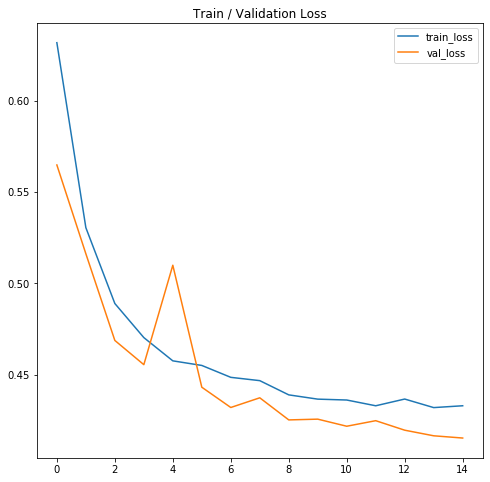

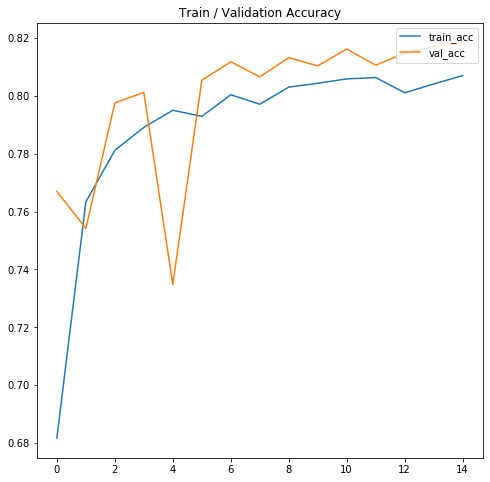

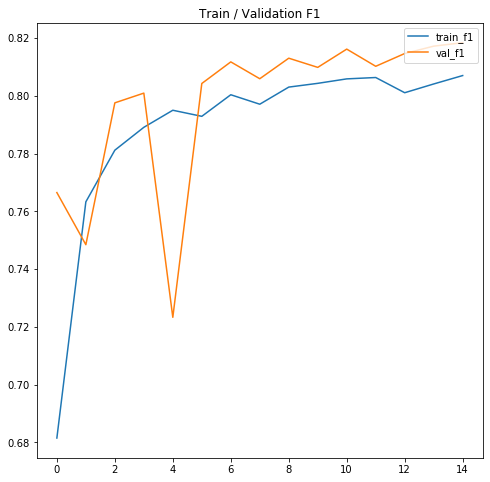

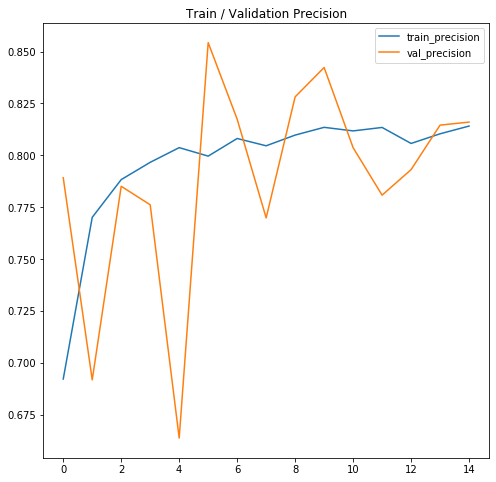

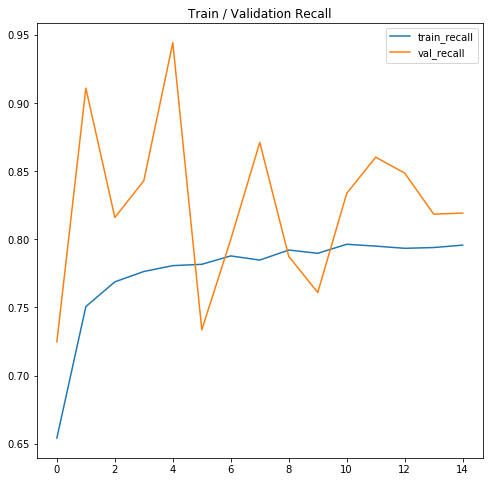

In [170]:
plot_results(history)

In [171]:
torch.save(base_model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}_{MODEL_NAME}_{NUM_EPOCHS}.bin')

In [172]:
val_dataset = tokenized_dataset['test']

In [173]:
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2 * config['batch_size'])

In [174]:
val_loss, val_preds, val_labels = eval_epoch(base_model, val_dataloader)
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds)
val_recall = recall_score(val_labels, val_preds)

100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


In [175]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.4165196858346462
Val acc: 0.8171
Val f1: 0.8170998829439251
Val precision: 0.8178182181781822
Val recall: 0.8166749875187219


## Space Model

In [198]:
base_model = AutoModel.from_pretrained(MODEL_NAME)
base_model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [199]:
space_model = SpaceModelForSequenceClassification(base_model, n_embed=768, n_latent=3, n_concept_spaces=2, l1=0.2, l2=0.001).to(device)
space_model

SpaceModelForSequenceClassification(
  (base_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [200]:
count_parameters(space_model)

4622

In [201]:
ids = val_dataset[0]['input_ids'].unsqueeze(0)
mask = val_dataset[0]['attention_mask'].unsqueeze(0)
targets = val_dataset[0]['label'].unsqueeze(0)

ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)

base_embed = space_model.base_model(ids, mask).last_hidden_state

concept_spaces = space_model.space_model(base_embed).concept_spaces

In [202]:
print(f'Inter-space loss: {space_model.l1 * inter_space_loss(concept_spaces) * BATCH_SIZE}')

Inter-space loss: 51.41680908203125


In [203]:
print(f'Intra-space loss: {space_model.l2 * intra_space_loss(concept_spaces) * BATCH_SIZE}')

Intra-space loss: 57.639739990234375


In [ ]:
space_history = training(space_model, tokenized_dataset['train'], tokenized_dataset['val'], config)

Train steps: 1464
Epoch: 1


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.9389480674753383 | Val loss: 0.8688752949237823
Train acc: 0.51304 | Val acc: 0.5978
Train f1: 0.37155806990510926 | Val f1: 0.5683989015741313
Train precision: 0.7554858934169278 | Val precision: 0.6958677685950413
Train recall: 0.03856 | Val recall: 0.33883299798792754
Epoch: 2


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.8507031682802706 | Val loss: 0.8338669776916504
Train acc: 0.63852 | Val acc: 0.638
Train f1: 0.6265875539034316 | Val f1: 0.629159397371318
Train precision: 0.7156020420869132 | Val precision: 0.6026772132643748
Train recall: 0.45976 | Val recall: 0.7971830985915493
Epoch: 3


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.8202353235410185 | Val loss: 0.8058926284313201
Train acc: 0.71248 | Val acc: 0.7432
Train f1: 0.7119815668202765 | Val f1: 0.7431496573328371
Train precision: 0.6961595273264402 | Val precision: 0.7323017408123791
Train recall: 0.75408 | Val recall: 0.7617706237424547
Epoch: 4


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.7911732397517379 | Val loss: 0.7763289749622345
Train acc: 0.76852 | Val acc: 0.7696
Train f1: 0.768516221814366 | Val f1: 0.7680707886607876
Train precision: 0.770707315106057 | Val precision: 0.7281752824375214
Train recall: 0.76448 | Val recall: 0.8559356136820926
Epoch: 5


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.7608937663691384 | Val loss: 0.7474457085132599
Train acc: 0.78708 | Val acc: 0.7938
Train f1: 0.7870790430480511 | Val f1: 0.7937750467806605
Train precision: 0.7883024021852655 | Val precision: 0.7828793774319066
Train recall: 0.78496 | Val recall: 0.8096579476861167
Epoch: 6


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]



Train loss: 0.7350666766264 | Val loss: 0.7244193017482757
Train acc: 0.7954 | Val acc: 0.796
Train f1: 0.7953956705723894 | Val f1: 0.7959047773329124
Train precision: 0.7981429148163101 | Val precision: 0.7792603888677088
Train recall: 0.7908 | Val recall: 0.8225352112676056
Epoch: 7


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Train loss: 0.714123086053498 | Val loss: 0.7054539084434509
Train acc: 0.80032 | Val acc: 0.797
Train f1: 0.8003152446273616 | Val f1: 0.7969677666026258
Train precision: 0.8032800129261594 | Val precision: 0.7851047323506595
Train recall: 0.79544 | Val recall: 0.814486921529175
Epoch: 8


 59%|█████▉    | 58/98 [00:35<00:24,  1.63it/s]

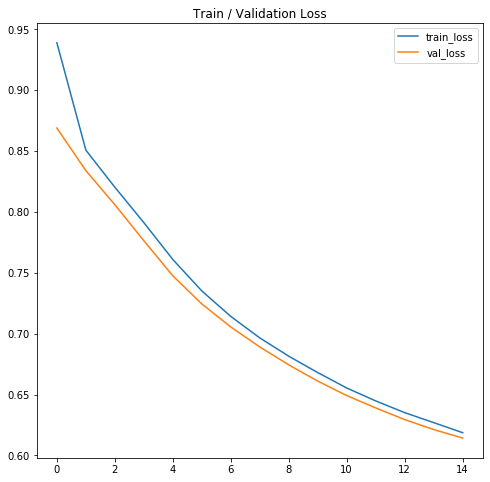

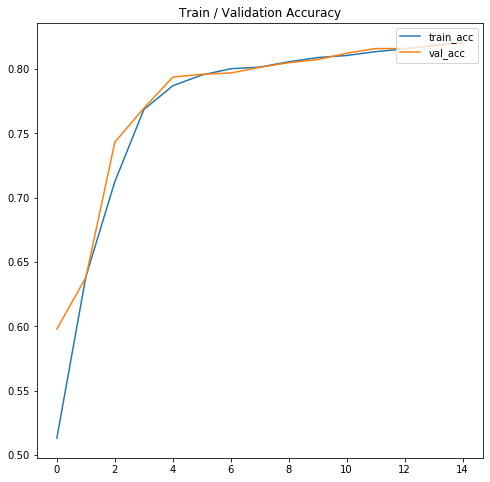

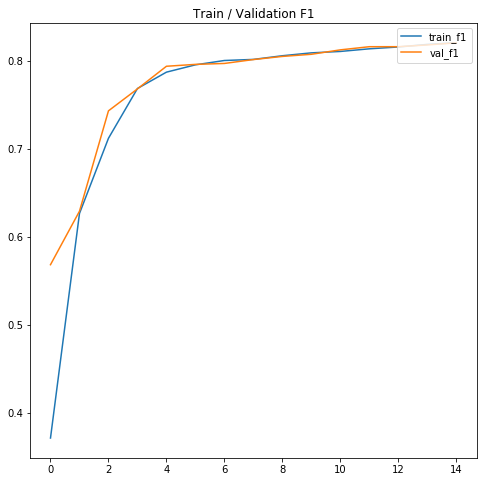

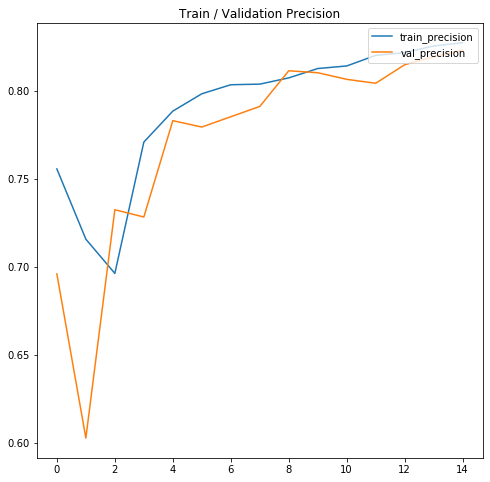

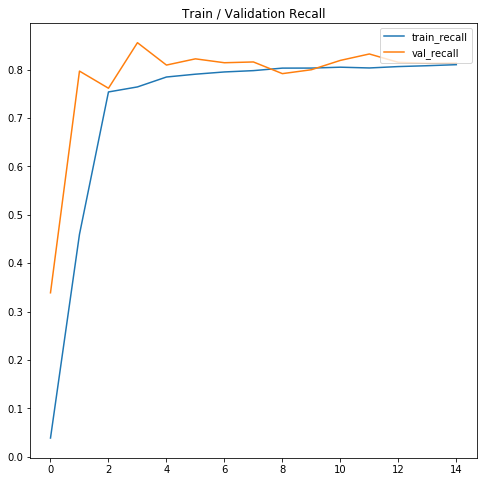

In [205]:
plot_results(space_history)

In [206]:
val_loss, val_preds, val_labels = eval_epoch(space_model, val_dataloader)

100%|██████████| 40/40 [00:43<00:00,  1.09s/it]


In [207]:
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds)
val_recall = recall_score(val_labels, val_preds)

In [208]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.6163146063685417
Val acc: 0.8192
Val f1: 0.819181554710396
Val precision: 0.827046918123275
Val recall: 0.8078881677483775


In [209]:
torch.save(space_model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}_space-{MODEL_NAME}_{NUM_EPOCHS}.bin')

### Interpretation

In [193]:
test_dataset = tokenized_dataset['unsupervised']

In [194]:
# examples with less than 16 words are easier to visualize, so focus on them
examples_ids = []
for i, v in enumerate(list(test_dataset['input_ids'])):
    s = [t for t in v.cpu() if t != tokenizer.pad_token_id]
    if len(s) <= 16:
        examples_ids.append(i)
print(examples_ids)

[8132, 37527, 46980]


In [195]:
scatters = []
colors = ['blue', 'red']
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataset[sample_index]
    tokens = [tokenizer.decode(t) for t in test_tokenized_batch['input_ids'] if t != tokenizer.pad_token_id]
    seq_len = len(tokens)

    input_ids = test_tokenized_batch['input_ids'].to(device).unsqueeze(0)
    attention_mask = test_tokenized_batch['attention_mask'].to(device).unsqueeze(0)

    base_embed = space_model.base_model(input_ids, attention_mask).last_hidden_state

    concept_spaces = space_model.space_model(base_embed).concept_spaces

    print()

    for c, embed in enumerate(concept_spaces):
        x, y, z = embed[0, :seq_len, 0].detach().cpu().numpy(), embed[0, :seq_len, 1].detach().cpu().numpy(), embed[0, :seq_len, 2].detach().cpu().numpy()

        scatters.append(go.Scatter3d(
            x=x, y=y, z=z, mode='markers+text',
            name=f'Example: {sample_index} ({c})',
            text=tokens,
            marker=dict(color=colors[c]),
            # hovertext=[]
        ))

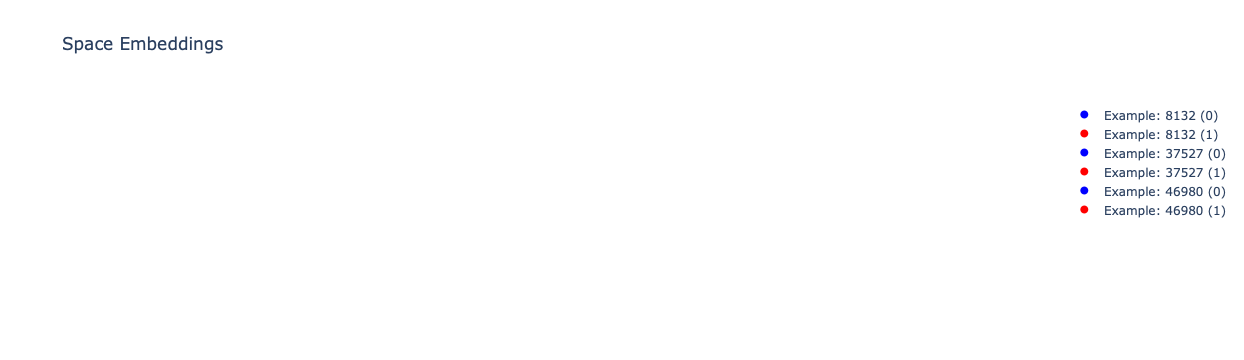

In [196]:
fig = go.Figure(
    data=scatters,
    layout=go.Layout(
        title=go.layout.Title(text='Space Embeddings')
    ))
fig.show()

In [197]:
fig.write_html(f'plots/{DATASET_NAME}_space-{MODEL_NAME}_{NUM_EPOCHS}.html')

In [192]:
# space_bert = SpaceBertForSequenceClassification(bert, n_embed=768, n_latent=3, n_concept_spaces=2, l1=0, l2=0).to(device)
# space_bert.load_state_dict(torch.load(f'{MODELS_PATH}/ce_loss_2_epochs.bin'))
# space_bert